# Applying the CRISP-DM Method to a Business Problem

# 1. Stage One - Determine Business Objectives and Assess the Situation  <a class="anchor" id="Businessunderstanding"></a>




The fraud transaction detection dataset is a simulated dataset of original and fraudulent transactions.

The simulated frauds were generated following these scenarios:

* **High amount rule:** Any transaction with an amount > 220 is marked as fraud.


* **Compromised terminals:** Each day, 2 terminals are randomly selected; for the next 28 days, all their transactions are fraudulent (e.g., phishing).


* **Compromised customers:** Each day, 3 customers are randomly selected; for the next 14 days, one-third of their transactions are multiplied by 5 and marked as fraudulent (simulating card-not-present fraud with stolen credentials).


Main Columns

* **TRANSACTION_ID:** Unique transaction identifier

* **TX_DATETIME:** Date and time of transaction

* **CUSTOMER_ID:** Unique customer identifier

* **TERMINAL_ID:** Unique merchant/terminal identifier

* **TX_AMOUNT:** Transaction amount

* **TX_FRAUD:** Fraud label (0 = legitimate, 1 = fraud)

 ## 1.1 What Questions Are We Trying To Answer? <a class="anchor" id="QA"></a>

* Does the model correctly distinguish among transactions and classify them correctly?

## 1.2 Success metrics

* Predict at least 80% of Non-Fraud records on a test set.

* Predict at least 90% of Fraud records on a test set



# 2. Stage  Two - Data Understanding <a class="anchor" id="Dataunderstanding"></a>


## 2.1 Initial Data Report <a class="anchor" id="Datareport"></a>
Initial data collection report


In [ ]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install joblib
!pip install scikit-learn
!pip install scipy
!pip install keras
!pip install keras-tuner
!pip install scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.8 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import pandas.api.types as pdtypes
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform, loguniform
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score
)
import keras
import tensorflow as tf
from tensorflow.keras import layers, callbacks
from tensorflow.keras.saving import register_keras_serializable
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, InputLayer
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import keras_tuner as kt
from scikeras.wrappers import KerasClassifier
import joblib
from google.colab import drive
import json


In [ ]:
plt.style.use('bmh')
pd.set_option('display.max_columns', 40)
pd.set_option("display.max_colwidth", None)


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
datasets_path = "/content/drive/My Drive/Colab Notebooks/Unified Mentor Projects/Datasets/fraud_detection/dataset/data"


In [ ]:
X=None
y=None
random_state=42
test_size=0.3
for filename in os.listdir(datasets_path):
           df = pd.read_pickle(datasets_path+"/"+filename)
           X= pd.concat([X, df])



## 2.2 Describe Data <a class="anchor" id="Describedata"></a>


###2.2.1 Variables description

| Variable | Description | Type |
|-----------|--------------|------|
| **TRANSACTION_ID** | Unique identifier for each transaction | Numerical (Discrete) |
| **TX_DATETIME** | Date and time when the transaction occurred | Datetime |
| **CUSTOMER_ID** | Unique identifier for the customer making the transaction | Numerical (Discrete) |
| **TERMINAL_ID** | Unique identifier for the terminal where the transaction occurred | Numerical (Discrete) |
| **TX_AMOUNT** | Amount of money involved in the transaction (in currency units) | Numerical (Continuous) |
| **TX_TIME_SECONDS** | Time of the transaction in seconds since the first recorded transaction | Numerical (Continuous) |
| **TX_TIME_DAYS** | Number of days since the first recorded transaction | Numerical (Continuous) |
| **TX_FRAUD_SCENARIO** | Simulated fraud pattern applied to the transaction:<br>**0** = Not Fraudulent<br>**1** = Fraud due to high amount (>220)<br>**2** = Fraud from compromised terminals (28-day window)<br>**3** = Fraud from compromised customers (14-day window) | Categorical (Ordinal) |


In [ ]:
X.sample(10)

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
1462315,1462315,2018-08-31 13:05:57,3020,7025,36.32,13179957,152,0,0
1632727,1632727,2018-09-18 09:50:20,1873,4521,6.69,14723420,170,0,0
1293280,1293280,2018-08-13 18:39:44,3859,2986,22.45,11644784,134,0,0
326057,326057,2018-05-04 21:00:40,2122,3580,34.60,2926840,33,0,0
1594687,1594687,2018-09-14 10:10:55,2485,4318,74.82,14379055,166,0,0
607532,607532,2018-06-03 09:49:18,799,8178,7.38,5478558,63,0,0
1607338,1607338,2018-09-15 14:45:55,1839,5223,21.06,14481955,167,0,0
1601786,1601786,2018-09-15 05:32:29,4361,1264,124.45,14448749,167,0,0
1597786,1597786,2018-09-14 14:44:40,4411,1562,31.94,14395480,166,0,0
1576145,1576145,2018-09-12 11:18:59,2193,9704,29.06,14210339,164,0,0


In [ ]:
X.query("TX_FRAUD_SCENARIO == 0").sample(10)

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
998450,998450,2018-07-14 05:32:05,3982,4888,26.18,9005525,104,0,0
526694,526694,2018-05-25 18:24:06,1301,6646,16.66,4731846,54,0,0
1606271,1606271,2018-09-15 13:08:52,968,3456,16.05,14476132,167,0,0
279493,279493,2018-04-30 05:41:44,2666,1300,17.36,2526104,29,0,0
1743689,1743689,2018-09-29 19:13:23,3595,4747,115.82,15707603,181,0,0
1331193,1331193,2018-08-17 18:11:12,2708,8792,119.42,11988672,138,0,0
1138295,1138295,2018-07-28 15:22:33,4996,5962,5.30,10250553,118,0,0
115094,115094,2018-04-13 01:13:08,2581,7904,114.91,1041188,12,0,0
109948,109948,2018-04-12 11:39:24,1908,6495,30.14,992364,11,0,0
1071982,1071982,2018-07-21 16:14:23,2590,1730,64.01,9648863,111,0,0


In [ ]:
X.query("TX_FRAUD_SCENARIO == 1").sample(10)

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
769862,769862,2018-06-20 08:34:33,3959,6205,231.04,6942873,80,1,1
457669,457669,2018-05-18 14:23:13,2513,2403,238.26,4112593,47,1,1
1200607,1200607,2018-08-04 08:00:13,4691,7245,223.03,10828813,125,1,1
1183504,1183504,2018-08-02 11:09:47,74,3091,255.00,10667387,123,1,1
1127045,1127045,2018-07-27 12:43:25,2322,2108,227.10,10154605,117,1,1
1081941,1081941,2018-07-22 17:16:29,2496,534,222.35,9738989,112,1,1
1107712,1107712,2018-07-25 12:41:37,3282,4353,250.30,9981697,115,1,1
1014427,1014427,2018-07-15 16:11:02,2225,9434,220.84,9130262,105,1,1
1735822,1735822,2018-09-29 04:38:33,4757,4012,226.37,15655113,181,1,1
1274965,1274965,2018-08-11 23:08:51,3726,9249,259.18,11488131,132,1,1


In [ ]:
X.query("TX_FRAUD_SCENARIO == 2").sample(10)

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
597286,597286,2018-06-02 08:43:18,455,293,6.98,5388198,62,1,2
1243105,1243105,2018-08-08 14:07:26,805,9251,73.04,11196446,129,1,2
222604,222604,2018-04-24 07:23:03,3774,1921,57.95,2013783,23,1,2
1172682,1172682,2018-08-01 09:19:40,4494,6136,0.99,10574380,122,1,2
261547,261547,2018-04-28 08:37:36,765,5952,97.79,2363856,27,1,2
1351125,1351125,2018-08-19 20:25:53,701,4473,8.62,12169553,140,1,2
1669345,1669345,2018-09-22 06:11:46,1560,6338,36.91,15055906,174,1,2
1587685,1587685,2018-09-13 13:53:43,757,2024,58.62,14306023,165,1,2
1263836,1263836,2018-08-10 16:55:27,4223,4923,12.67,11379327,131,1,2
1539757,1539757,2018-09-08 14:27:25,1731,2352,5.53,13876045,160,1,2


In [ ]:
X.query("TX_FRAUD_SCENARIO == 3").sample(10)

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
1144523,1144523,2018-07-29 10:32:24,3379,6594,25.50,10319544,119,1,3
1662587,1662587,2018-09-21 11:06:08,100,2464,105.55,14987168,173,1,3
503820,503820,2018-05-23 11:40:31,2780,1615,247.50,4534831,52,1,3
1164386,1164386,2018-07-31 11:22:21,1955,8241,92.10,10495341,121,1,3
1576381,1576381,2018-09-12 11:38:41,1085,9823,254.60,14211521,164,1,3
556249,556249,2018-05-28 20:20:04,4368,2252,447.60,4998004,57,1,3
351256,351256,2018-05-07 13:15:19,4092,4278,386.55,3158119,36,1,3
261717,261717,2018-04-28 08:54:52,4163,6386,947.40,2364892,27,1,3
528674,528674,2018-05-26 04:59:38,79,2668,893.65,4769978,55,1,3
176047,176047,2018-04-19 10:15:57,357,6111,185.40,1592157,18,1,3


In [ ]:
X.shape

(1754155, 9)

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1754155 entries, 0 to 1725491
Data columns (total 9 columns):
 #   Column             Dtype         
---  ------             -----         
 0   TRANSACTION_ID     int64         
 1   TX_DATETIME        datetime64[ns]
 2   CUSTOMER_ID        object        
 3   TERMINAL_ID        object        
 4   TX_AMOUNT          float64       
 5   TX_TIME_SECONDS    object        
 6   TX_TIME_DAYS       object        
 7   TX_FRAUD           int64         
 8   TX_FRAUD_SCENARIO  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 133.8+ MB


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1754155 entries, 0 to 1725491
Data columns (total 9 columns):
 #   Column             Dtype         
---  ------             -----         
 0   TRANSACTION_ID     int64         
 1   TX_DATETIME        datetime64[ns]
 2   CUSTOMER_ID        object        
 3   TERMINAL_ID        object        
 4   TX_AMOUNT          float64       
 5   TX_TIME_SECONDS    object        
 6   TX_TIME_DAYS       object        
 7   TX_FRAUD           int64         
 8   TX_FRAUD_SCENARIO  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 133.8+ MB


###2.2.2 Split dataset into train, valdation, and test sets

In [ ]:
X["TX_DATETIME"] = pd.to_datetime(X["TX_DATETIME"])
X = X.sort_values("TX_DATETIME").reset_index(drop=True)

In [ ]:

n = len(X)
train_end = int(0.70 * n)
val_end = int(0.85 * n)

X_train = X.iloc[:train_end].reset_index(drop=True)
X_val = X.iloc[train_end:val_end].reset_index(drop=True)
X_test = X.iloc[val_end:].reset_index(drop=True)

y_train = X_train["TX_FRAUD"]
y_val = X_val["TX_FRAUD"]
y_test = X_test["TX_FRAUD"]

In [ ]:
cover_counts = y_train.value_counts().sort_index()

cover_percentages = (cover_counts / len(y_train)) * 100

counts_percentages_df = pd.DataFrame({
    'Cover Type': cover_counts.index,
    'Count': cover_counts.values,
    'Percentage': cover_percentages.round(2)

})

display(counts_percentages_df)


,Cover Type,Count,Percentage
TX_FRAUD,,,
0,0,1217912,99.19
1,1,9996,0.81


As we can see, X_train has  imbalance.

In [ ]:
numeric_cols = X_train.select_dtypes(include=["object","float64"]).columns
numeric_cols = numeric_cols[~numeric_cols.str.contains('ID')]

categorical_cols = X_train.select_dtypes(include=["int64",]).columns
categorical_cols = categorical_cols[~categorical_cols.str.contains('ID')]


In [ ]:

cat_summary = pd.DataFrame({
    "Column": categorical_cols,
    "Num Unique": [X_train[col].nunique() for col in categorical_cols],
    "Categories": [X_train[col].unique().tolist() for col in categorical_cols]
})

display(cat_summary)

,Column,Num Unique,Categories
0,TX_FRAUD,2,"[0, 1]"
1,TX_FRAUD_SCENARIO,4,"[0, 1, 3, 2]"


###2.2.3 Numerical variables

Statistics for the numerical columns are:

* **count:** The number of non-null values.

* **mean:** The average.

* **std:** The standard deviation, which measures the dispersion of the data.

* **min:** The minimum value.

* **25%:** The first quartile (25th percentile).

* **50%:** The median (50th percentile).

* **75%:** The third quartile (75th percentile).

* **max:** The maximum value.

In [ ]:
X_train[numeric_cols].describe().round(2)

,TX_AMOUNT
count,1227908.00
mean,53.63
std,42.15
min,0.00
25%,21.02
50%,44.65
75%,76.96
max,1108.85


The transaction amounts are concentrated around small to medium values, but there are a few very large transactions that cause the distribution to be right-skewed.

###2.2.4 Categorical variables

* **count:** The number of non-null values.

* **unique:** The number of unique values in the column.

* **top:** The most frequent value in the column.

* **freq:** The frequency (number of occurrences) of the most frequent value.

In [ ]:
X_train[categorical_cols].describe().round(2)

,TX_FRAUD,TX_FRAUD_SCENARIO
count,1227908.00,1227908.00
mean,0.01,0.02
std,0.09,0.21
min,0.00,0.00
25%,0.00,0.00
50%,0.00,0.00
75%,0.00,0.00
max,1.00,3.00


Standard summary statistics (mean, std, percentiles) are not reliable for these categorical classifiers.

## 2.3 Verify Data Quality <a class="anchor" id="Verifydataquality"></a>



### 2.3.1. Missing Data <a class="anchor" id="MissingData"></a>


In [ ]:
X_train.isnull().sum()

,0
TRANSACTION_ID,0
TX_DATETIME,0
CUSTOMER_ID,0
TERMINAL_ID,0
TX_AMOUNT,0
TX_TIME_SECONDS,0
TX_TIME_DAYS,0
TX_FRAUD,0
TX_FRAUD_SCENARIO,0


In [ ]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = (100 * df.isnull().sum()) / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

In [ ]:
missing_values_table(X_train)

Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


## 2.4 Initial Data Exploration  <a class="anchor" id="Exploredata"></a>


### 2.4.1 Distributions  <a class="anchor" id="Distributions"></a>




In [ ]:
def plot_target_distribution(X_df, y_series, target_name="TX_FRAUD"):
    """Plots the distribution of the target variable."""
    df = X_df.assign(**{target_name: y_series})

    fig, ax = plt.subplots(figsize=(5, 4))
    plot = sns.countplot(x=target_name, data=df, ax=ax)
    ax.set_title(f"{target_name} Distribution", fontsize=12, fontweight="bold")
    ax.bar_label(ax.containers[0], fmt="%d", label_type="center")
    plt.tight_layout()
    plt.show()


def plot_numeric_boxplots(X_df, y_series, target="TX_FRAUD"):
    """Plots boxplots for each numeric column grouped by the target."""
    df = X_df.assign(**{target: y_series})
    n_cols = 3
    n_rows = int(np.ceil(len(numeric_cols) / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        sns.boxplot(x=target, y=col, data=df, ax=axes[i])
        axes[i].set_title(f"{col} vs {target}")

    # Hide any extra axes
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


def plot_categorical_stacked(X_df, y_series, target="TX_FRAUD"):
    """Plots stacked bar charts showing categorical distributions by target."""
    df = X_df.assign(**{target: y_series})
    n_cols = 1
    n_rows = int(np.ceil(len(categorical_cols) / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows))

    # Ensure axes is iterable
    if n_rows * n_cols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for i, col in enumerate(categorical_cols):
        cross_tab = pd.crosstab(df[col], df[target], normalize="index") * 100
        cross_tab.plot(kind="bar", stacked=True, ax=axes[i], colormap="viridis", legend=False)
        axes[i].set_ylabel("Percentage")
        axes[i].set_title(f"{col} vs {target}")
        axes[i].legend(title=target)



    plt.tight_layout()
    plt.show()


def plot_numeric_correlation(X_df, y_series, target="TX_FRAUD", biserial=False, numeric_cols=None):
    """
    Plots correlation heatmaps for numeric columns.

    """

    # Combine data
    df = X_df.assign(**{target: y_series})
    if numeric_cols is None:
        numeric_cols = df.select_dtypes(include="number").columns.drop(target)


    #  NORMAL CORRELATION HEATMAP
    if not biserial:
        corr = df[numeric_cols].corr()
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
        plt.title("Correlation Heatmap (Numerical Variables)")
        plt.tight_layout()
        plt.show()
        return


    #BISERIAL MODE

    fraud_df = df[df[target] == 1]
    nonfraud_df = df[df[target] == 0]

    corr_fraud = fraud_df[numeric_cols].corr()
    corr_nonfraud = nonfraud_df[numeric_cols].corr()

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.heatmap(corr_fraud, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[0])
    axes[0].set_title('Fraudulent Transactions')

    sns.heatmap(corr_nonfraud, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[1])
    axes[1].set_title('Non-Fraudulent Transactions')

    plt.tight_layout()
    plt.show()


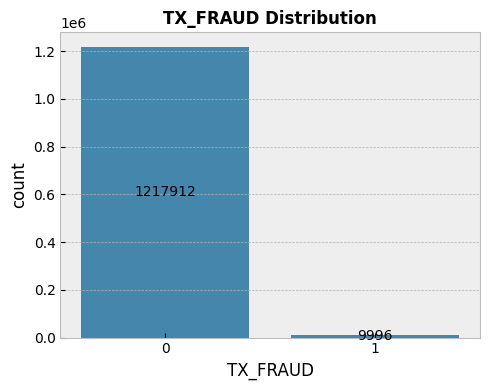

In [ ]:
plot_target_distribution(X_df=X_train, y_series=y_train)

The dataset shows moderate variation but no critical class imbalance. Standard modeling approaches can be applied without mandatory imbalance correction.

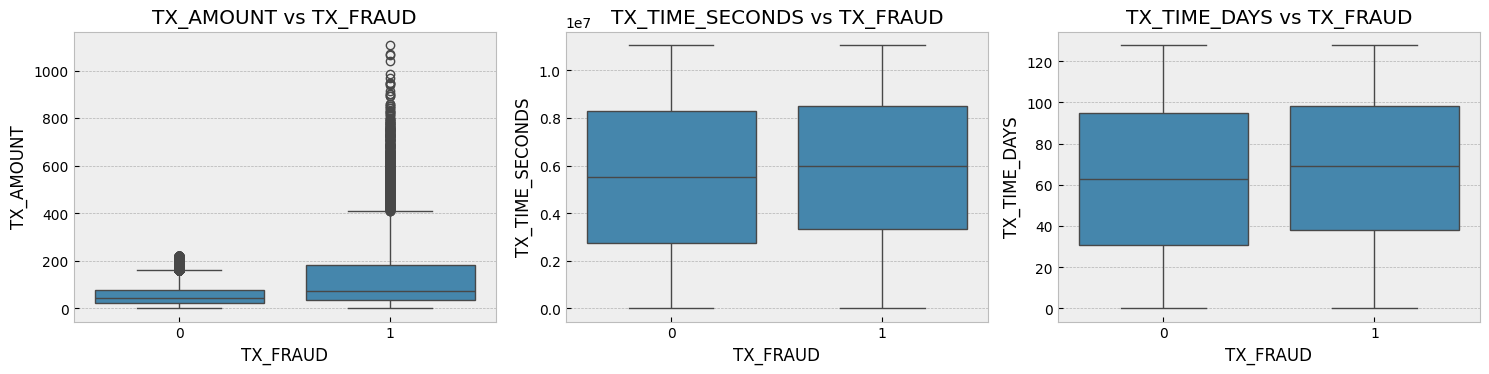

In [ ]:
boxplot_graphs=plot_numeric_boxplots(X_df=X_train, y_series=y_train)

Several features show clear variations across cover types, indicating good predictive potential. Outliers are present and should be addressed in subsequent preprocessing.

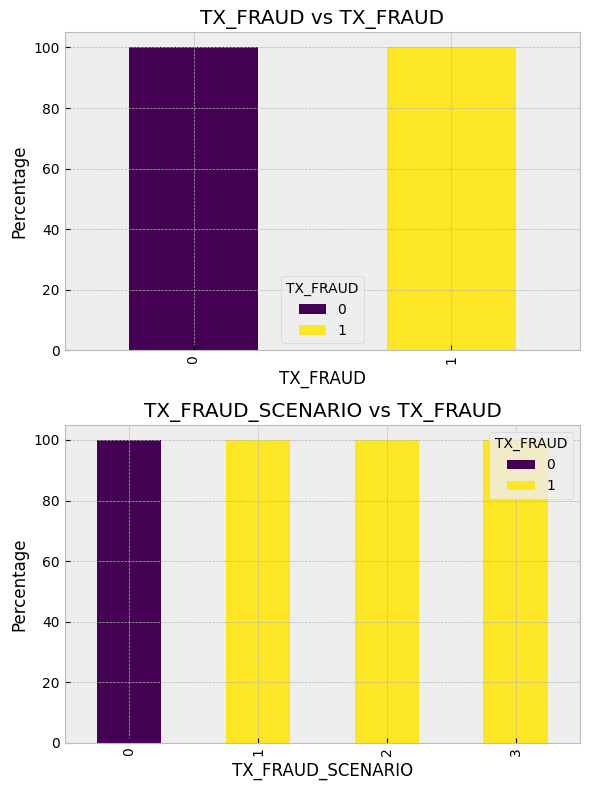

In [ ]:
categorical_graphs=plot_categorical_stacked(X_df=X_train, y_series=y_train)

 Most soil types are strongly associated with just 1-2 specific cover types, making them highly predictive. Wilderness areas also show clear, distinct cover type preferences.

### 2.4.2 Correlations  <a class="anchor" id="Correlations"></a>


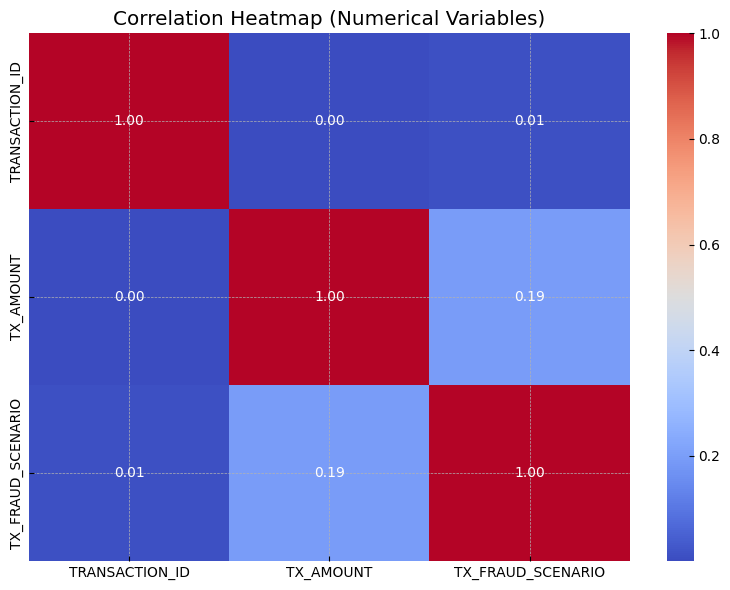

In [ ]:
plot_numeric_correlation(X_df=X_train, y_series=y_train)


Transaction amount shows no correlation with time variables. Furthermore, the time variables are perfectly correlated with each other, as they are all derived from the same datetime variable.

**Note:** If there are two variables perfectly correlated, we will remove one of them.





## 2.5 Data Quality Report <a class="anchor" id="Dataqualityreport"></a>


**Section summary:**
From this information, we can already see that there are no null values. Furthermore, we can see several ID variables. While these are non-predictive by nature, they will be retained for now to facilitate feature engineering, as they are crucial for capturing meaningful data representations, in line with our project constraints.


Notes:
* ID columns will be removed after capturing meaningful representations.

* To prevent overfitting and data leakage, we will remove TX_FRAUD_SCENARIO and use feature engineering to create meaningful variables to represent the initial scenarios.

# Stage Three - Data Preparation <a class="anchor" id="Cleansethedata"></a>


###3.1 Feature Engineering

In [ ]:
import pandas as pd
import numpy as np

# --- Compute terminal-level features ---
def compute_terminal_features(df):
    def _apply_group(x):
        x = x.set_index('TX_DATETIME')
        fraud_count_7d = x['TX_FRAUD'].rolling('7d', min_periods=1).sum().shift(1).fillna(0)
        tx_count_7d = x['TX_AMOUNT'].rolling('7d', min_periods=1).count().shift(1).fillna(0)
        x['terminal_fraud_ratio_7d'] = fraud_count_7d / (tx_count_7d + 1e-3)
        return x.reset_index()
    return df.groupby('TERMINAL_ID', group_keys=False).apply(_apply_group)

# --- Compute customer-level features ---
def compute_customer_features(df):
    def _apply_group(x):
        x = x.sort_values('TX_DATETIME').set_index('TX_DATETIME')
        x['customer_fraud_count_14d'] = x['TX_FRAUD'].rolling('14d', min_periods=1).sum().shift(1).fillna(0)
        mean30 = x['TX_AMOUNT'].rolling('30d', min_periods=1).mean().shift(1).fillna(0)
        std30 = x['TX_AMOUNT'].rolling('30d', min_periods=1).std().shift(1).fillna(0)
        x['z_amount_30d'] = (x['TX_AMOUNT'] - mean30) / (std30 + 1e-3)
        return x.reset_index()
    return df.groupby('CUSTOMER_ID', group_keys=False).apply(_apply_group)

# Create copies for feature engineering (WITH IDs)
fe_train = X_train.copy()
fe_val = X_val.copy()
fe_test = X_test.copy()

# Ensure sorted
for tmp in [fe_train, fe_val, fe_test]:
    tmp.sort_values(['TERMINAL_ID', 'TX_DATETIME'], inplace=True)

print("Computing terminal features...")
fe_train = compute_terminal_features(fe_train)
fe_val = compute_terminal_features(fe_val)
fe_test = compute_terminal_features(fe_test)

print("Computing customer features...")
fe_train = compute_customer_features(fe_train)
fe_val = compute_customer_features(fe_val)
fe_test = compute_customer_features(fe_test)

# Reset indices
fe_train = fe_train.reset_index(drop=True)
fe_val = fe_val.reset_index(drop=True)
fe_test = fe_test.reset_index(drop=True)


X_train = fe_train.drop(columns=['TX_FRAUD'])
X_val = fe_val.drop(columns=['TX_FRAUD'])
X_test = fe_test.drop(columns=['TX_FRAUD'])

Computing terminal features...


/tmp/ipython-input-584098107.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('TERMINAL_ID', group_keys=False).apply(_apply_group)
/tmp/ipython-input-584098107.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('TERMINAL_ID', group_keys=False).apply(_apply_group)
/tmp/ipython-input-584098107.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping 

Computing customer features...


/tmp/ipython-input-584098107.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('CUSTOMER_ID', group_keys=False).apply(_apply_group)
/tmp/ipython-input-584098107.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('CUSTOMER_ID', group_keys=False).apply(_apply_group)
/tmp/ipython-input-584098107.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping 

* **terminal_fraud_ratio_7d:**

(frauds on this terminal in last 7 days) ÷ (total txs on this terminal in last 7 days).

Shows the fraction of fraudulent transactions made at a terminal in the past 7 days.
When a terminal is attacked, this ratio quickly rises close to 1 and stays high for about 28 days, so a value above 0.5 signals ongoing fraud activity.

* **customer_fraud_count_14d:**

Flags the 14-day leaked-customer window despite the 1-in-3 fraud sparsity.

If the count is ≥1 during the compromise period, the model simply checks whether count > 0 to detect that the customer is currently leaked.

* **z_amount_30d:**

Measures how unusual the current transaction amount is compared to the customer’s 30-day average (in standard deviations).

A z-score above 3 means the amount is abnormally high,often about 5× the customer’s usual spending, and likely fraudulent.

### 3.2 Drop Unnecessary Columns <a class="anchor" id="DropCols"></a>



In [ ]:
drop_cols = ["TX_DATETIME", "TX_FRAUD_SCENARIO", "TX_TIME_DAYS"]

def clean_dataset(df_):
    df_ = df_.drop(columns=drop_cols, errors="ignore")
    # drop any column that contains "ID" (TERMINAL_ID, CUSTOMER_ID, TRANSACTION_ID, etc.)
    df_ = df_.drop(columns=[c for c in df_.columns if "ID" in c], errors="ignore")
    return df_

X_train_raw = clean_dataset(fe_train.drop(columns=["TX_FRAUD"], errors="ignore")).copy()
X_val_raw = clean_dataset(fe_val.drop(columns=["TX_FRAUD"], errors="ignore")).copy()
X_test_raw = clean_dataset(fe_test.drop(columns=["TX_FRAUD"], errors="ignore")).copy()

y_train = fe_train["TX_FRAUD"].astype(int).reset_index(drop=True)
y_val = fe_val["TX_FRAUD"].astype(int).reset_index(drop=True)
y_test = fe_test["TX_FRAUD"].astype(int).reset_index(drop=True)

### 3.3 Datatypes

In [ ]:
X_train_num = X_train_raw.apply(pd.to_numeric, errors="coerce")
X_val_num = X_val_raw.apply(pd.to_numeric, errors="coerce")
X_test_num = X_test_raw.apply(pd.to_numeric, errors="coerce")

# Convert back to DataFrame for ColumnTransformer
feature_names = X_train_raw.columns.tolist()
X_train_clean = pd.DataFrame(X_train_num, columns=feature_names)
X_val_clean = pd.DataFrame(X_val_num, columns=feature_names)
X_test_clean = pd.DataFrame(X_test_num, columns=feature_names)

### 3.4 Dealing With Duplicates <a class="anchor" id="DealingDuplicates"></a>









In [ ]:
X_train.shape

(1227908, 11)

In [ ]:
X_val.shape

(263123, 11)

In [ ]:
X_test.shape

(263124, 11)

In [ ]:
drop_cols = ["TX_DATETIME", "TX_FRAUD_SCENARIO", "TX_TIME_DAYS","TX_FRAUD"]

def clean_dataset(df):
    df = df.drop(columns=drop_cols, errors="ignore")
    df = df.drop(columns=[col for col in df.columns if "ID" in col], errors="ignore")
    return df



X_train_clean = clean_dataset(X_train_clean)
X_val_clean = clean_dataset(X_val_clean)
X_test_clean = clean_dataset(X_test_clean)

#numeric_cols = numeric_cols.drop([col for col in numeric_cols if "ID" in col or col in drop_cols], errors="ignore")
numeric_cols=X_train_clean.columns.tolist()

categorical_cols = []


In [ ]:
X_train_clean.shape

(1227908, 5)

In [ ]:
X_val_clean.shape

(263123, 5)

In [ ]:
X_test_clean.shape

(263124, 5)

**Note:** Outlier removal will not be applied because they are our fraud cases, and the normalization process will be made in the following steps.

Correlation among all variables

In [ ]:
X_train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1227908 entries, 0 to 1227907
Data columns (total 5 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   TX_AMOUNT                 1227908 non-null  float64
 1   TX_TIME_SECONDS           1227908 non-null  int64  
 2   terminal_fraud_ratio_7d   1227908 non-null  float64
 3   customer_fraud_count_14d  1227908 non-null  float64
 4   z_amount_30d              1227908 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 46.8 MB


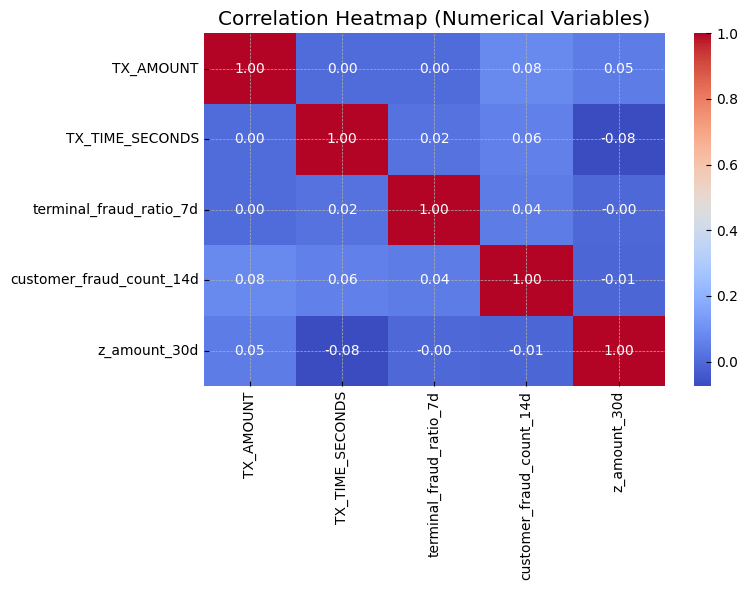

In [ ]:
plot_numeric_correlation(X_df=X_train_clean, y_series=y_train)

Plot numerical correlations again

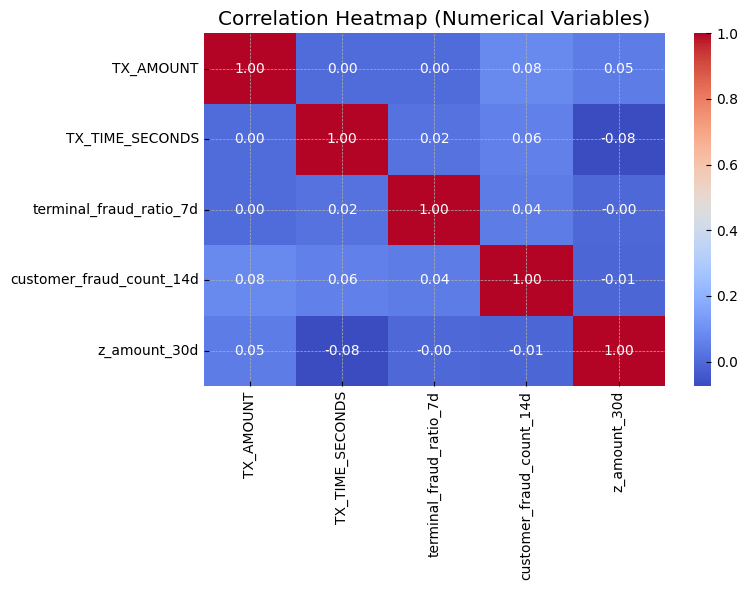

In [ ]:
plot_numeric_correlation(X_df=X_train_clean, y_series=y_train)

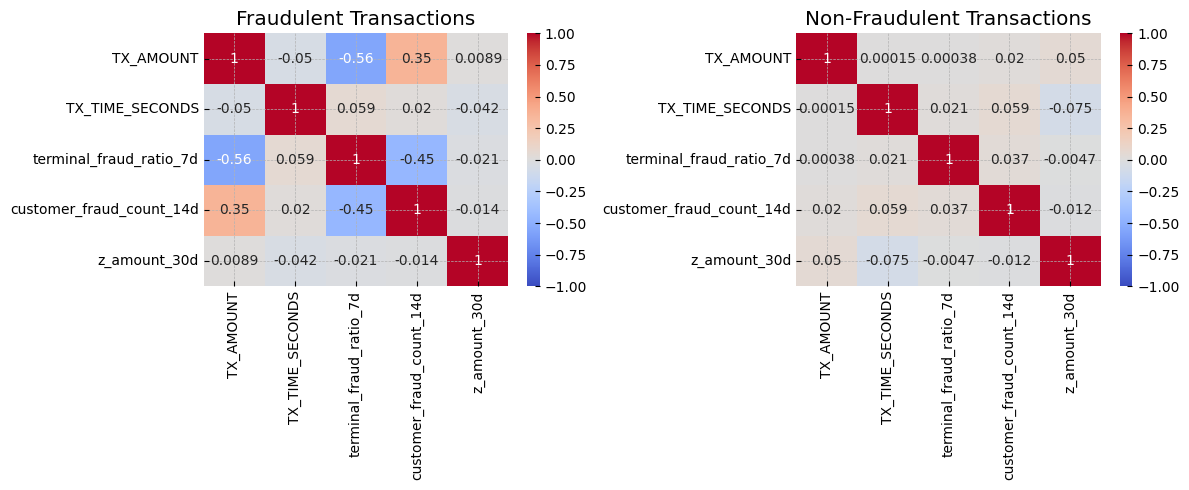

In [ ]:
plot_numeric_correlation(X_df=X_train_clean, y_series=y_train, biserial=True)

# 4. Stage Four - Modelling <a class="anchor" id="Modelling"></a>



In [ ]:


def build_lr_pipeline(numeric_cols, categorical_cols):
    preprocessor = ColumnTransformer([
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_cols),
        ('cat', 'passthrough', categorical_cols)
    ])

    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(max_iter=1000, random_state=random_state))
    ])
    return pipeline

In [ ]:

# Logistic Regression
param_distributions_lr = {
    'classifier__C': loguniform(1e-2, 1e2),
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs', 'saga'],
    'classifier__class_weight': ['balanced', {0: 1, 1: 50}, {0: 1, 1: 100}]
}


In [ ]:
# Define models and pipelines
models = {
    'LogisticRegression': build_lr_pipeline(numeric_cols, categorical_cols)
}

# Parameter distributions
param_distributions = {
    'LogisticRegression': param_distributions_lr
}

# Store results
results = {}

def train_model(model_name):
    """Train a single model with RandomizedSearchCV"""
    pipeline = models[model_name]
    print("Working on", model_name)

    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_distributions[model_name],
        n_iter=20,
        scoring='roc_auc',
        cv=5,
        verbose=1,
        n_jobs=1,
        random_state=random_state
    )

    # Fit the model
    random_search.fit(X_train_clean, y_train)

    # Save the best model
    joblib.dump(random_search.best_estimator_, f'best_model_{model_name}.pkl')
    print(model_name, "finished.")

    return model_name, random_search


# Train only Logistic Regression (no concurrency)
model_name, random_search = train_model('LogisticRegression')

# Save results
results[model_name] = random_search

print(f"{model_name} Best Parameters:", random_search.best_params_)
print(f"{model_name} Best CV Score (ROC AUC):", random_search.best_score_)


Working on LogisticRegression
Fitting 5 folds for each of 20 candidates, totalling 100 fits
LogisticRegression finished.
LogisticRegression Best Parameters: {'classifier__C': np.float64(8.471801418819979), 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
LogisticRegression Best CV Score (ROC AUC): 0.9746393555378647


Neural network

In [ ]:
cw = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), cw))

In [ ]:


@register_keras_serializable()
class CompletePreprocessingLayer(tf.keras.layers.Layer):
    def __init__(self, trainable=True, dtype=tf.float32, **kwargs):
        super().__init__(trainable=trainable, dtype=dtype, **kwargs)
        self.normalization = tf.keras.layers.Normalization()
        self._medians_initialized = False

    def build(self, input_shape):
        # Initialize medians with zeros
        self.medians = self.add_weight(
            name='medians',
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=False
        )
        # Build the normalization layer
        self.normalization.build(input_shape)
        super().build(input_shape)

    def adapt(self, data):
        # Convert to numpy for median calculation
        if hasattr(data, 'numpy'):
            data_np = data.numpy()
        else:
            data_np = np.array(data)

        medians = np.nanmedian(data_np, axis=0).astype(np.float32)

        # Build layer if not built
        if not self.built:
            self.build(tf.TensorShape([None, medians.shape[0]]))

        # Update medians
        self.medians.assign(medians)
        self._medians_initialized = True

        # Adapt normalization
        data_imputed = np.nan_to_num(data_np, nan=medians)
        self.normalization.adapt(data_imputed)

    def call(self, inputs):
        if not self._medians_initialized and not self.built:
            # If not adapted, build with input shape
            self.build(inputs.shape)

        # Impute missing values using medians
        x_imputed = tf.where(tf.math.is_nan(inputs), self.medians, inputs)
        return self.normalization(x_imputed)

    def get_config(self):
        return super().get_config()

    @classmethod
    def from_config(cls, config):
        layer = cls(**config)
        layer._medians_initialized = True
        return layer


In [ ]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.InputLayer(input_shape=(X_train_clean.shape[1],)))  # Use raw data shape!

    # ADD PREPROCESSING LAYER HERE - handles everything automatically
    preprocessing_layer = CompletePreprocessingLayer()
    preprocessing_layer.adapt(X_train_clean.values)  # Learn from training data
    model.add(preprocessing_layer)

    # Tune number of layers
    num_layers = hp.Int('num_layers', 1, 3)

    for i in range(num_layers):
        # Tune number of units per layer
        units = hp.Int(f'units_{i}', min_value=64, max_value=512, step=64)

        model.add(layers.Dense(units=units, activation='relu'))

        # Tune batch normalization
        if hp.Boolean(f'batch_norm_{i}'):
            model.add(layers.BatchNormalization())

        # Tune dropout rate
        dropout_rate = hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)
        model.add(layers.Dropout(rate=dropout_rate))

    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))

    # Tune learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    # Tune optimizer
    optimizer_choice = hp.Choice('optimizer', ['adam'])

    if optimizer_choice == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[
            keras.metrics.AUC(name='auc'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.Precision(name='precision')
        ]
    )

    return model

# ---------------------------------------------------------------------
# 8) Set up Keras Tuner - NOW PASS RAW DATA!
# ---------------------------------------------------------------------
def run_hyperparameter_tuning():
    # Define the tuner
    tuner = kt.BayesianOptimization(
        hypermodel=build_model,
        objective=kt.Objective("val_auc", direction="max"),
        max_trials=2,
        directory='keras_tuner',
        project_name='fraud_detection',
        overwrite=True
    )

    # Define callbacks for tuning
    tuning_callbacks = [
        callbacks.EarlyStopping(
            monitor='val_auc',
            patience=5,
            mode='max',
            restore_best_weights=True
        ),
        callbacks.ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5, patience=4, verbose=1),
        callbacks.ModelCheckpoint("best_dense_model.keras", monitor="val_auc", mode="max", save_best_only=True, verbose=1)
    ]

    print("Starting hyperparameter search...")
    print(f"Maximum trials: 15")


    tuner.search(
        X_train_clean.values, y_train,
        validation_data=(X_val_clean.values, y_val),
        epochs=10,
        batch_size=1024,
        class_weight=class_weights,
        callbacks=tuning_callbacks,
        verbose=1
    )

    return tuner

# Run hyperparameter tuning
print("Initializing hyperparameter tuning with built-in preprocessing...")
tuner = run_hyperparameter_tuning()

Trial 2 Complete [00h 12m 08s]
val_auc: 0.9622424840927124

Best val_auc So Far: 0.9686989188194275
Total elapsed time: 00h 16m 54s


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve
import keras
import numpy as np
model = keras.models.load_model(
    "best_dense_model.keras",
    custom_objects={"CompletePreprocessingLayer": CompletePreprocessingLayer}
)
y_val_prob = model.predict(X_val_clean)
# Compute ROC curve and find optimal threshold
fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Optimal Threshold:", optimal_threshold)

8223/8223 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step
Optimal Threshold: 0.43639314


**EarlyStopping**

Stops training when val_auc stops improving to avoid overfitting.

Note: AUC is used because it reflects how well the model separates fraud from normal cases overall.

**ReduceLROnPlateau**

Lowers the learning rate when val_auc plateaus to refine learning.

Note: AUC is used because it captures both recall and false positives, key for imbalanced fraud data.

**ModelCheckpoint**
Saves the model only when val_auc reaches a new best score.

Note: AUC is used because it ensures the saved model performs best at distinguishing fraud vs. non-fraud across all thresholds.

# 5. Stage five - Model Evaluation <a class="anchor" id="ModelEvaluation"></a>



In [ ]:


def plot_confusion_matrix(y_test,y_pred):
  cm = confusion_matrix(y_test, y_pred, labels=[0,1],normalize="true")

  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=[0,1])
  disp.plot(cmap="Blues")
  plt.title("Confusion Matrix")
  plt.show()



## 5.1. Model Performance Assessment <a class="anchor" id="Model Performance Assessment"></a>


In [ ]:
# Save the optimal threshold to a JSON file
with open('optimal_threshold.json', 'w') as f:
    json.dump({'threshold': float(optimal_threshold)}, f)

with open('optimal_threshold.json', 'r') as f:
    threshold_data = json.load(f)
    optimal_threshold_loaded = threshold_data['threshold']

8223/8223 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step


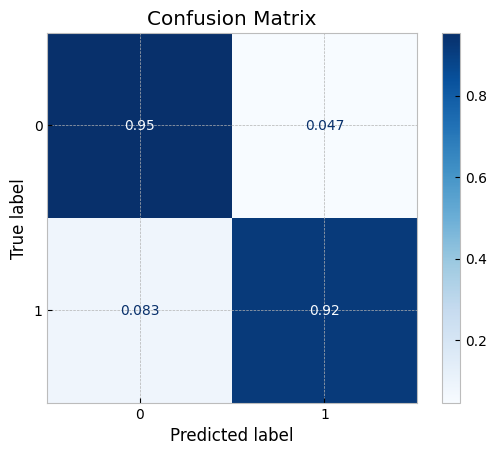

In [ ]:

model= keras.models.load_model("best_dense_model.keras")


y_test_pred = model.predict(X_test_clean)

y_pred=(y_test_pred >= optimal_threshold_loaded).astype(int)


plot_confusion_matrix(y_test, y_pred)



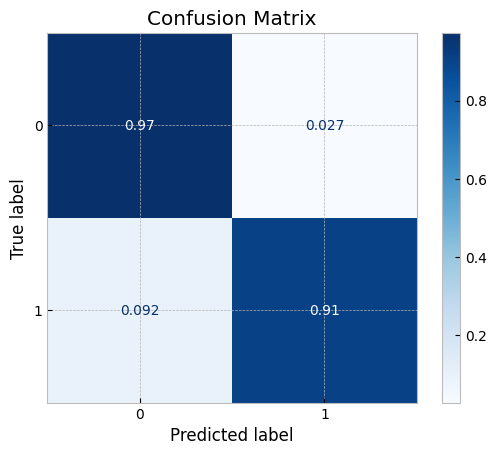

In [ ]:
model = joblib.load("best_model_LogisticRegression.pkl")
y_pred = model.predict(X_test_clean)

plot_confusion_matrix(y_test,y_pred)


## 5.2 Model Selection


Best: Logistic regression for interpretability

Both models meet business requirements.

In [ ]:
joblib.dump(model, f'/content/drive/My Drive/Colab Notebooks/Unified Mentor Projects/Best models/logistic_regression.pkl')

# 6. Stage six - Deployment <a class="anchor" id="Deployment"></a>


Still not implemented